In [2]:
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

In [1]:
def Leslie(fecundity, survival):
    n = len(fecundity)
    survival = survival[:n-1]
    L = zero_matrix(QQ, n)
    for i, b in enumerate(fecundity):
        L[0, i] = b
    for i, s in enumerate(survival):
        L[i + 1, i] = s
    return(L)



def is_essentially_real(x):
    if x.imag() == 0:
        return(True)
    else:
        return(False)
    
#Use of "if is_essentiallY_real(e)" rather than "if e in RR" is required since some computational errors
#    seem to come up in the eigenvalue computation, giving us things like x + 0.?e-80*I.

def get_leading_eigenvalue(L):
    evals = L.eigenvalues()
    moduli = [e.n() for e in evals if is_essentially_real(e)]
    moduli = [e for e in moduli if e >= 0]
    r = max(moduli)
    return(r)

def normalize(vec):
    tot = sum(vec)
    vec = vec/tot
    return(vec)

def get_leading_evec(L):
    r = get_leading_eigenvalue(L)
    evecs = L.eigenvectors_right()
    arrs = [e[0].n() for e in evecs]
    i = arrs.index(r)
    leading_evec = evecs[i][1][0]
    leading_evec = normalize(leading_evec).n()
    return(leading_evec)

In [3]:
def increased_fec(fec, by, at):
    new_fec = deepcopy(fec)
    new_fec[at] = fec[at] + by
    return(new_fec)

def increased_fitness(inc_fec, surv):
    L_inc = Leslie(inc_fec, surv)
    r = get_leading_eigenvalue(L_inc)
    return r


In [4]:
def required_increase(fec, surv, at, r0):
    '''
    For given fecundity and survival, returns required increase to fecundity at "at" to increase fitness to r0
    '''
    def g(b):
        inc_fec = increased_fec(fec, b, at)
        r1 = increased_fitness(inc_fec, surv)
        return r1 - r0
#    F = bisection(g, 0, 20)   #Required before (see sagemath ask.com for my question and how it was fixed)
    F = find_root(g, 0, 200000 )
    return(F)

In [5]:
def growth_of_P(fec, surv, P, verbose = False):
    n = len(fec)
    appreciation_vector = [0]*n
    appreciation_vector[0] = P
    inc_fec0 = increased_fec(fec, P, 0)
    r0 = increased_fitness(inc_fec0, surv)
    for a in range(1, floor(n)):
        F_a = required_increase(fec, surv, a, r0)
        appreciation_vector[a] = F_a
        if verbose:
            print('appreciated to {}'.format(a))
    return(appreciation_vector)

def plot_growth_of_P(fec, surv, P, verbose = False):
    app_vec = growth_of_P(fec, surv, P, verbose)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(app_vec))), y=app_vec,
                    mode='markers'))
    fig.show()

#### Above gives everything needed to visualize necessary appreciation of fecundity bump $P$ at age 0. 

#### Proceed to compute survival probabilities $s_a$ in the context of Squirrel Banking with a period of parental care.

In [6]:
def normalize(P0, P1, P2):
    p0 = P0/(P0 + P1 + P2)
    p1 = P1/(P0 + P1 + P2)
    p2 = 1 - p0 - p1
    return([p0, p1, p2])

def single_Lnow(p0, p1, p2):
    L = zero_matrix(QQ, 2)
    L[0,0] = p1
    L[1, 0] = p2
    L[0, 1] = (p1+p2)
    L[1, 1] = 0
    return L

def single_Lpatient(p0, p1, p2):
    L = zero_matrix(QQ, 3)
    L[0,0] = p1
    L[1,0] = p2
    L[2, 0] = 0
    L[0, 1] = p0
    L[1, 1] = p1
    L[2, 1] = p2
    L[0, 2] = p0
    L[1, 2] = (p1 + p2)
    L[2, 2] = 0

    return L

def single_L_betahat(p0, p1, p2, betahat, double_pregnancy = False, s = 1):
    normalized = normalize(p0, p1, p2)
    p0 = normalized[0]
    p1 = normalized[1]    
    p2 = normalized[2]
    if betahat == 0:
        L = Lnow(p0, p1, p2)
    elif betahat == 1:
        L = Lpatient(p0, p1, p2)
    else:
        L = zero_matrix(QQ, betahat + 2)
        for i in range(betahat+1):
            L[i, i] = p1
            if i < betahat+1:
                L[i + 1, i] = p2
                if i > 0:
                    L[i-1, i] = p0
        L[0, betahat+1] = 0
        L[betahat - 1, betahat+1] = p0
        L[betahat, betahat+1] = (p1 + p2)
        L[betahat+1, betahat+1] = 0      
    return(L)

def Lnow(p0, p1, p2, double_pregnancy = False):
    L = zero_matrix(QQ, 2)
    L[0,0] = p1
    L[1, 0] = p2
    if double_pregnancy == False:
        L[0, 1] = 2*(p1+p2)
        L[1, 1] = 0
    else:
        L[0, 1] = 2*p1 + p2
        L[1, 1] = p2
    return L

def Lpatient(p0, p1, p2, double_pregnancy = False):
    L = zero_matrix(QQ, 3)
    L[0,0] = p1
    L[1,0] = p2
    L[2, 0] = 0
    L[0, 1] = p0
    L[1, 1] = p1
    L[2, 1] = p2 
    L[0, 2] = 1 + p0
    if double_pregnancy == False:
        L[1, 2] = p1 + p2
        L[2, 2] = 0
    else:
        L[1, 2] = p1
        L[2, 2] = p2
    return L

def L_betahat(p0, p1, p2, betahat, double_pregnancy = False):
    normalized = normalize(p0, p1, p2)
    p0 = normalized[0]
    p1 = normalized[1]    
    p2 = normalized[2]
    if betahat == 0:
        L = Lnow(p0, p1, p2, double_pregnancy)
    elif betahat == 1:
        L = Lpatient(p0, p1, p2, double_pregnancy)
    else:
        L = zero_matrix(QQ, betahat + 2)
        for i in range(betahat+1):
            L[i, i] = p1
            if i < betahat+1:
                L[i + 1, i] = p2
                if i > 0:
                    L[i-1, i] = p0
        L[0, betahat+1] = 1
        L[betahat - 1, betahat+1] = p0
        if double_pregnancy == False:
            L[betahat, betahat+1] = p1 + p2
            L[betahat+1, betahat+1] = 0
        else:
            L[betahat, betahat + 1] = p1
            L[betahat+1, betahat+1] = p2           
    return(L)


In [7]:
def get_surv(L, len_surv = 10):
    betahat = L.dimensions()[0] - 2
    v = vector([1] + [0]*(betahat+1))
    
    surv = []
    for _ in range(len_surv):
        prob_alive = sum(v)
        v = L*v
        s = sum(v)/prob_alive
        surv.append(s)
        
    return surv    

#### Now we know the survival probability of a squirrel in squirrel banking. We also know its fitness. So construct a Leslie matrix with accurate survival probability and constant fecundity yielding the same fitness. This will give us enough to determine the squirrel's evolutionarily optimal discounting schedule.

#### I think I overcomplicated things a bit. All that really matters is survival vector, so let's focus on getting that.

In [68]:
def get_inverse_surv(p0, p1, p2, betahat, num_days = 10):
    L = single_L_betahat(p0, p1, p2, betahat)
    surv = get_surv(L, len_surv = num_days)
    inverse_surv = [1/prod(surv[:k]).n() for k in range(len(surv))]
    return inverse_surv

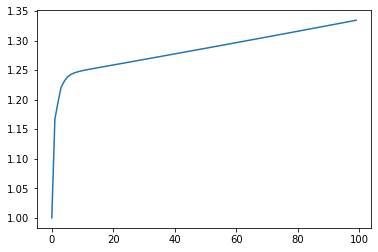

In [112]:
plt.plot(get_inverse_surv(1, 1, 5, 3, 100))

In [96]:
get_leading_eigenvalue(L_betahat(1.1, 1, 1, 3))

0.979815546318089

In [74]:
def get_appreciation_vec(p0, p1, p2, betahat, num_days = 10):
    fitness = get_leading_eigenvalue(L_betahat(p0, p1, p2, betahat))
    inverse_surv = get_inverse_surv(p0, p1, p2, betahat, num_days)
    appreciation_vec = [fitness^k*inverse_surv[k].n() for k in range(len(inverse_surv))]
    return appreciation_vec

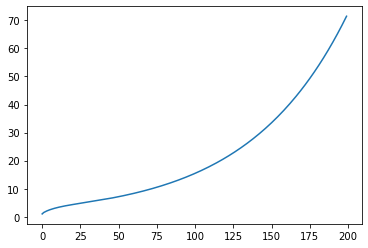

In [115]:
plt.plot(get_appreciation_vec(1, 1, 1, 5, 200))

In [63]:
get_leading_eigenvalue(L_betahat(1, 1, 1.1, 10))

1.00337760515434

In [88]:
normalize(1, 1, 1.1)

[0.322580645161290, 0.322580645161290, 0.354838709677419]